# Imports & Data Loading

In [48]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import os

current_path = os.getcwd()
path = os.path.join(current_path, "data", "resampled", "ANOVA_selected_features.csv")
df= pd.read_csv(path)
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train.shape

(21518, 99)

# Reports Generation & Saving Functions

In [49]:
current_dataset_name = os.path.split(path)[1].split('.')[0]

In [50]:
def save_report(report:dict, model, dataset_version:str = "v1", notes:str = "", test_type:str = "Classification", dataset_name:str=current_dataset_name):
    with sqlite3.connect("data/models_reports.db") as conn:
        cursor = conn.cursor()

        cursor.execute("""
            INSERT INTO TEST_METADATA (model_name, dataset_name, dataset_version, test_type, notes)
            VALUES (?, ?, ?, ?, ?)
        """ , (type(model).__name__, dataset_name, dataset_version, test_type, notes)
       )

        # Get the auto-generated test_id
        test_id = cursor.lastrowid

        cursor.execute("""
            INSERT INTO MODEL_PARAMETERS (test_id, hyperparameters)
            VALUES (? , ? )
        """, (test_id,str(model.get_params()))
        )


        cursor.execute("""
            INSERT INTO METRICS (test_id, anomaly, normal, accuracy, macro_avg, weighted_avg)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (
            test_id,
            str(report["anomaly"]),
            str(report["normal"]),
            str(report["accuracy"]),
            str(report["macro avg"]),
            str(report["weighted avg"])
        )
   )

        conn.commit()

In [51]:
from sklearn.metrics import classification_report

def generate_metric_report(model, y_true:np.array, y_pred:np.array, db_save:bool=False)->pd.DataFrame:
    # Using sklearn's classification report, then converting it to dataframe
    report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True))

    report = report.iloc[:-1, :] # excluding last row
    report = report * 100 # convert into percentage

    # Rounding to 2 decimals for each col
    for i, col in enumerate(report.columns):
        report.iloc[:, i] = report.iloc[:, i].apply(lambda v: round(v, 2))

    # save to db
    if db_save:
        save_report(report.to_dict('series'), model)

    return report

# Model 1: SVM Classifier

#### Model Fine-Tuning

In [52]:
# Comparing different normalizations parameters and comparing their recall percentage
# we will use "Parallel" and "delayed" from joblib to execute code in parallel
from joblib import Parallel, delayed

c_range = np.arange(0.01, 3, 0.2)
recalls = []

def try_c_value(c):
    clf_svc = SVC(kernel="linear", C=c)
    clf_svc.fit(X_train, y_train)
    svc_pred = clf_svc.predict(X_test)
    return generate_metric_report(clf_svc, y_test, svc_pred).loc["recall"]["anomaly"]

recalls = Parallel(n_jobs=-1)(delayed(try_c_value)(c) for c in c_range)


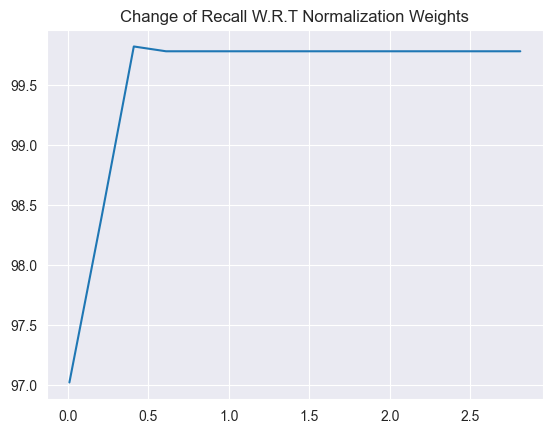

In [53]:
# Visualizing the change of Recall W.R.T normalization weights

sns.lineplot(x=c_range,y= recalls)
plt.title("Change of Recall W.R.T Normalization Weights")
plt.show()

In [54]:
best_c = c_range[np.argsort(recalls)[-1]]
best_c

0.41000000000000003

#### Model Training

In [55]:
# Using the best normalization parameter
clf_svc = SVC(kernel = "linear", C = best_c)
clf_svc.fit(X_train, y_train)
svc_pred = clf_svc.predict(X_test)
generate_metric_report(clf_svc, y_test, svc_pred)

,anomaly,normal,accuracy,macro avg,weighted avg
precision,98.71,99.81,99.24,99.26,99.24
recall,99.82,98.63,99.24,99.22,99.24
f1-score,99.26,99.21,99.24,99.24,99.24


# Model 2: Decision Tree Classifier

#### Model Training

In [56]:
# https://medium.com/data-science/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
from sklearn.tree import plot_tree, DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(
    max_depth=None,           # Maximum depth of the tree
    min_samples_split=2,      # Minimum number of samples required to split an internal node
    min_samples_leaf=1,       # Minimum number of samples required to be at a leaf node
    criterion='entropy',      # Function to measure the quality of a split
    random_state=5

)
dt_clf.fit(X_train, y_train)

decisionTree_pred = dt_clf.predict(X_test)

generate_metric_report(dt_clf, y_test, decisionTree_pred)

,anomaly,normal,accuracy,macro avg,weighted avg
precision,99.85,99.96,99.91,99.91,99.91
recall,99.96,99.85,99.91,99.91,99.91
f1-score,99.91,99.90,99.91,99.91,99.91


#### Model Visualization

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10), dpi=1000)

plot_tree(dt_clf, filled=True, feature_names=X_test.columns,
          class_names=['Anomaly', 'Normal'], impurity=False)
plt.show()

# Model 3: Random Forest Classifier

#### Model Training

In [58]:
# resources:
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
# https://medium.com/data-science/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(
    criterion='entropy',
    random_state=3,
    n_jobs = -1 ,#parallel processing
    max_features = "sqrt" #default=”sqrt”
)
forest.fit(X_train, y_train)
randomForest_pred = forest.predict(X_test)
generate_metric_report(forest, y_test, randomForest_pred)

,anomaly,normal,accuracy,macro avg,weighted avg
precision,100.00,99.92,99.96,99.96,99.96
recall,99.93,100.00,99.96,99.96,99.96
f1-score,99.96,99.96,99.96,99.96,99.96


#### Model Fine-Tuning (Not Completed)

In [59]:
# from sklearn.model_selection import GridSearchCV
# rf_grid = RandomForestClassifier()
# gr_space = {
#     'max_depth': [3, 5, 7, 10],
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_features': ["sqrt", "log2", None],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10],
#     "criterion": ["gini", "entropy", "log_loss"],
#     "bootstrap": [True, False],
#     "oob_score": [True, False],
#     # "random_state":  np.arange(0, 50),
#     "warm_start": [True, False],
#     # "ccp_alpha": np.linspace(0.0, 1.0, 20),
#
# }
#
#
# grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3 ,n_jobs=-1 )
# model_grid = grid.fit(X_train, y_train)
#
# print('best hyperparameters : '+str(model_grid.best_params_))
# print('best score : ' + str(model_grid.best_score_))

In [60]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

# rf = RandomForestClassifier()


# param_dist = {
#     'n_estimators': [100, 200, 300, 500, 700, 1000],
#     'max_depth': [3, 5, 10, 20, None],
#     'min_samples_leaf': [1, 2, 4, 8],
#     'max_features': ['sqrt', 'log2', None],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'bootstrap': [True, False],
#     'oob_score': [True, False],
#     'random_state': np.arange(0, 100),
#     'warm_start': [True, False],
#     'ccp_alpha': np.linspace(0.0, 1.0, 20)
# }


# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=50,  # Number of parameter settings sampled
#     cv=3,
#     verbose=3,
#     random_state=42,
#     scoring='accuracy',
#     n_jobs=-1  # Use all available cores
# )

# model = random_search.fit(X_train, y_train)

# print('best hyperparameters : '+str(model_grid.best_params_))
# print('best score : ' + str(model_grid.best_score_))


# Model 4: Logistic Regression

#### Model Fine-Tuning

In [61]:
from sklearn.linear_model import LogisticRegression

c_range = np.arange(0.2, 15, 0.2)

def try_c_value(c):
    log_reg_clf = LogisticRegression(random_state=0, max_iter=1000, C=c)
    log_reg_clf.fit(X_train, y_train)
    y_pred = log_reg_clf.predict(X_test)
    report = generate_metric_report(log_reg_clf, y_test, y_pred)
    return report.loc["recall"]["anomaly"], report.loc["f1-score"]["anomaly"]

results = Parallel(n_jobs=-1)(delayed(try_c_value)(c) for c in c_range)


In [62]:
recalls, f1_scores = zip(*results)

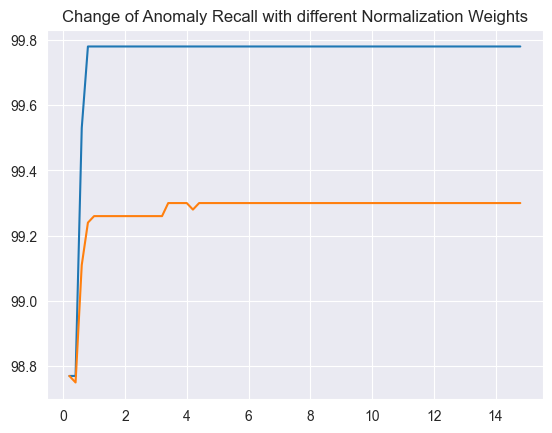

In [63]:
import seaborn as sns
# Visualizing the change of Anomaly Recall with different Normalization Weights
sns.lineplot(x=c_range,y= recalls)
sns.lineplot(x=c_range,y= f1_scores)

plt.title("Change of Anomaly Recall with different Normalization Weights")
plt.show()

In [64]:
best_c = c_range[max(enumerate(results), key=lambda x: (x[1][0], x[1][1]))[0]]

#### Model Training

In [65]:
log_reg_clf = LogisticRegression(random_state=0, max_iter=1000, C=best_c)
log_reg_clf.fit(X_train, y_train)
log_reg_pred = log_reg_clf.predict(X_test)
generate_metric_report(log_reg_clf, y_test, log_reg_pred)

,anomaly,normal,accuracy,macro avg,weighted avg
precision,98.81,99.77,99.28,99.29,99.28
recall,99.78,98.74,99.28,99.26,99.28
f1-score,99.30,99.25,99.28,99.27,99.27


# Ensemble Learning: Stacking

In [66]:
from sklearn.ensemble import StackingClassifier

# using all previous models
estimators = [
    ('svc', clf_svc),
    ('dt', dt_clf),
    ('rf', forest),
    ('log_reg', log_reg_clf),
]

# we use Random Forest as our final estimator
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), n_jobs=-1)
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)

generate_metric_report(stacking_clf, y_test, stacking_pred)

,anomaly,normal,accuracy,macro avg,weighted avg
precision,100.00,99.92,99.96,99.96,99.96
recall,99.93,100.00,99.96,99.96,99.96
f1-score,99.96,99.96,99.96,99.96,99.96
